In [1]:
from brownpy.gpu_sim import Universe
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from tqdm.auto import tqdm
plt.style.use('dark_background')

In [2]:
dt = int(1E6) #fs (1ns) - time steps
D = 1.5E-4 # A²/fs  (1.5E-9 m²/s) - Diffusion coefficient

# Geometry
L = 1E3 # A (100nm) - channel length
h = 1E2 # A (10nm)  - channel height
R = 1E4 # A (1um) - reservoir size

N= 8*1024

In [12]:
u = Universe(N=N, L=L, h=h, R=R, D=D, dt=dt,
             output_path='simu.nc')

simu.nc already exists, change output filename for simu_1.nc


In [4]:
u.run3(1_000_000_000);

100%|██████████| 10000000/10000000 [00:30<00:00, 350167.67it/s, total=10 ms]

In [14]:
rootgrp = Dataset('simu.nc', "r", format="NETCDF4")

In [18]:
rootgrp['particles'].N

8192

In [3]:
u = Universe.from_nc('simu.nc')

In [4]:
data = u[0]

Reading region_0 ...
... Done


In [7]:
data['trajectory'].shape

(8192, 2, 100000)

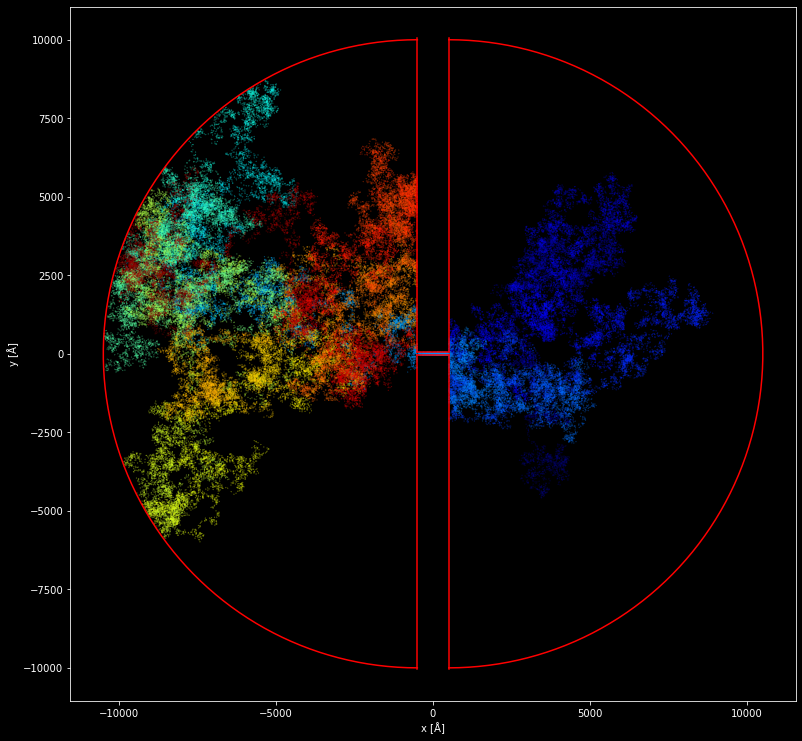

In [20]:
trajectory = data['trajectory']
# Get particles that go inside the channel
# i_particle=1107
fig, ax = plt.subplots(figsize=(13,13))
# ax.plot(trajectory[i_particle,0,:], trajectory[i_particle,1,:])
temp = np.argsort(np.sum(np.abs(trajectory[:,0,:-2])<L/2, axis=1))[::-1]
i_particle = temp[0]
ax.scatter(trajectory[i_particle,0,:], trajectory[i_particle,1,:], 
           c=np.arange(trajectory.shape[2]), marker='.', cmap='jet', s=0.1)
# for i_particle in temp[:1]:
#         ax.plot(trajectory[i_particle,0,:], trajectory[i_particle,1,:])

# for i_particle in range(trajectory.shape[0]):
#         ax.plot(trajectory[i_particle,0,:2], trajectory[i_particle,1,:2])
ax.plot(R*np.cos(np.linspace(np.pi/2, 3*np.pi/2, 100))-L/2,
        R*np.sin(np.linspace(np.pi/2, 3*np.pi/2, 100)),c='r')
ax.plot(-R*np.cos(np.linspace(np.pi/2, 3*np.pi/2, 100))+L/2,
        R*np.sin(np.linspace(np.pi/2, 3*np.pi/2, 100)),c='r')
ax.plot([-L/2, -L/2], [R+h/2, h/2], c='r')
ax.plot([+L/2, +L/2], [R+h/2, h/2], c='r')
ax.plot([-L/2, +L/2], [h/2, h/2], c='r')
ax.plot([-L/2, +L/2], [-h/2, -h/2], c='r')
ax.plot([-L/2, -L/2], [-R-h/2, -h/2], c='r')
ax.plot([+L/2, +L/2], [-R-h/2, -h/2], c='r')
ax.set_xlabel('x [Å]')
ax.set_ylabel('y [Å]')
ax.set_aspect('equal')
# ax.set_xlim(-2000,2000)
# ax.set_ylim(-2000,2000)


In [13]:
u.run2(1_000_000);



With 8192 particles
GPU time per step:
cp.zeros: 0.004 us
cp.random.normal: 2.819 us
engine: 0.001 us
Total: 2.824 us
Need 2.82s to compute 1ms of simulation


In [5]:
import cupy as cp
def PSD_gpu(x, dt):
    x_gpu = cp.asarray(x)
    psd = (cp.abs(cp.fft.rfft(x_gpu))**2).get()
    freqs = (cp.fft.rfftfreq(x.size, dt)).get()
    del x_gpu
    cp._default_memory_pool.free_all_blocks()
    return psd, freqs

def PSD_gpu_binned(x, dt, bins):
    x_gpu = cp.asarray(x)
    psd_gpu = cp.abs(cp.fft.rfft(x_gpu))**2
    freqs_gpu = cp.fft.rfftfreq(x.size, dt)

    psd_binned_gpu, freqs_binned_gpu = cp.histogram(cp.log(freqs_gpu)[1:], 
                                        weights=cp.log(psd_gpu)[1:], bins=bins)
    N_binned_gpu = cp.histogram(cp.log(freqs_gpu)[1:], bins=bins)[0]
    psd_averaged = (psd_binned_gpu/N_binned_gpu).get()
    freqs = ((freqs_binned_gpu[1:]+freqs_binned_gpu[:-1])/2.).get()
    
    del x_gpu, psd_gpu, freqs_gpu, psd_binned_gpu, freqs_binned_gpu, N_binned_gpu
    cp._default_memory_pool.free_all_blocks()
    return np.exp(psd_averaged), np.exp(freqs)

In [8]:
data = u[0]

Reading region_0 ...
... Done


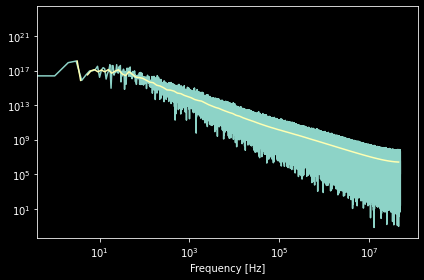

In [8]:
region_0 = data['region_0']
fig, ax = plt.subplots()
psd, freqs = PSD_gpu(region_0[::10], dt*10)
ax.loglog(freqs*1E15, psd)
psd_bin, freqs_bin = PSD_gpu_binned(region_0[::10], dt*10, bins=100)
ax.loglog(freqs_bin*1E15, psd_bin)
ax.set_xlabel('Frequency [Hz]')
fig.tight_layout()